## Anexa 2. Cod sursa - Aplicatia II - Regresie neliniara
## Rezistenta axiala beton

#### Importare module

In [1]:
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, BatchNormalization, Dropout
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from IPython.display import HTML, Image
seed = 314159
np.random.seed(seed)
import warnings
# warnings.filterwarnings('ignore')

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


#### Incarcare set de date si previzualizare

In [2]:
filename = "concrete_data_prepared.csv"
database = pd.read_csv(filename)
print('Previzualizare set de date:')
display(database.head())
print('Dimensiuni set de date =',database.shape)

Previzualizare set de date:


,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Dimensiuni set de date = (1030, 9)


#### Previzualizare grafica set de date de intrare

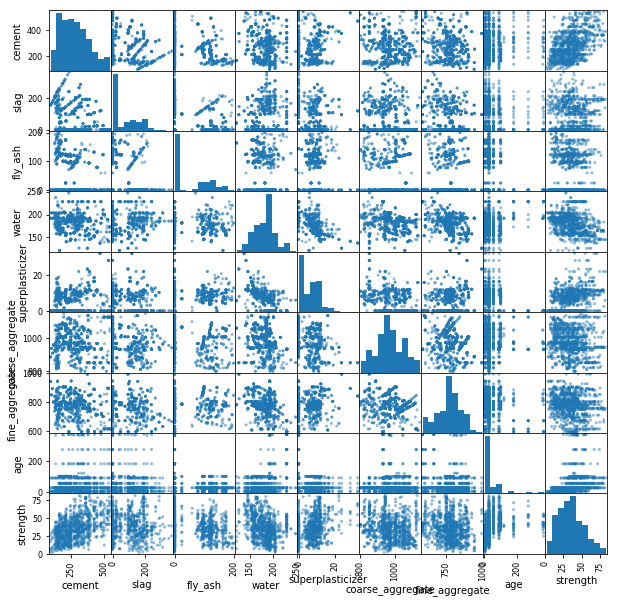

In [3]:
pd.plotting.scatter_matrix(database, figsize=(10, 10));

#### Matricea de corelatie

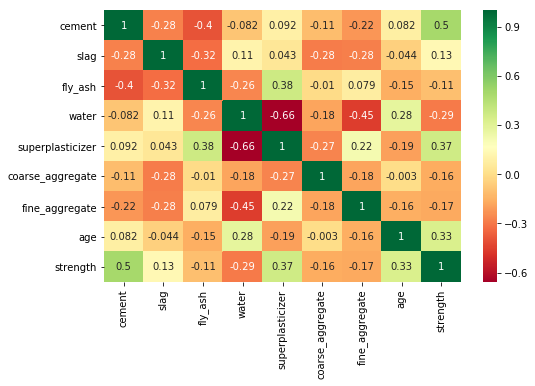

In [4]:
plt.subplots(figsize=(8, 5))
sns.heatmap(database.corr(), annot=True, cmap="RdYlGn")
plt.show()

### Date de antrenare si testare
Din setul total se vor folosi 75% din date pentru antrenarea modelului si 25 pentru testare. Se va studia influenta scalarii parametrilor de intrare. Datele de intrare for fi standardizate ($\mu=0$ , $\sigma=1$).

In [5]:
dataset = database.values
X_data = dataset[:, 0:8]
Y_data = dataset[:, 8]
X_train, X_test, Y_train, Y_test = train_test_split(dataset[:, 0:8], dataset[:, 8],
                                                    test_size=0.25, random_state=seed)
scaler_x = StandardScaler()
scaler_x.fit(X_data)
X_data_scaled=scaler_x.transform(X_data)

### Functia de definire a retelei neuronale

Se foloseste libraria Keras (API pentru Tensorflow) pentru construirea retelei neuronale

In [6]:
def runNN(X_train_set, Y_train_set, X_test_set, Y_test_set, 
          n_neurons, n_epochs, seed=seed, early_stopping=None):
    np.random.seed(seed)
    nn_model = Sequential()  # create model
    nn_model.add(Dense(n_neurons * 2, input_dim=8, kernel_initializer='normal', activation='relu'))  # hidden layer
    nn_model.add(Dense(n_neurons, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.01)))  # hidden layer
    nn_model.add(Dense(1, kernel_initializer='normal', activation='relu'))  # output layer
    nn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    model_callbacks = []
    if early_stopping is not None:
        model_callbacks = [early_stopping]
    model_output = nn_model.fit(X_train_set, Y_train_set, epochs=n_epochs, verbose=0,
                                    batch_size=X_train_set.shape[0], initial_epoch=0, callbacks=model_callbacks,
                                    validation_data=(X_test_set, Y_test_set))
    return model_output, nn_model

In [11]:
neurons = 8
nr_epochs = 30000
early_stop_crit = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                                patience=300, verbose=0, mode='auto')
start_time = time.time()
nn_output_unscaled, nn_1 = runNN(X_train, Y_train, X_test, Y_test, neurons, nr_epochs,
                                 early_stopping=early_stop_crit)
nn_output_scaled, nn_2 = runNN(scaler_x.transform(X_train), Y_train,scaler_x.transform(X_test),
                               Y_test, neurons, nr_epochs, early_stopping=early_stop_crit)
time_s = time.time() - start_time
print("Timp de antrenare %0.1f secunde / %0.1f minute / %0.1f ore" % (time_s,time_s/60,time_s/60/60) )

Timp de antrenare 66.8 secunde / 1.1 minute / 0.0 ore


#### Salvarea ponderilor celor doua modele

In [12]:
model_num = 2
nn_filename_scaled= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_unscaled.h5')))
hist_filename_scaled = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_unscaled.pickle')))
nn_1.save(nn_filename_scaled)  # creates a HDF5 file
with open(hist_filename_scaled, 'wb') as handle:
    pickle.dump(nn_output_unscaled.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
del nn_1
                                
nn_filename_unscaled= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_scaled.h5')))
hist_filename_unscaled = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_scaled.pickle')))
nn_2.save(nn_filename_unscaled)  # creates a HDF5 file
with open(hist_filename_unscaled, 'wb') as handle:
    pickle.dump(nn_output_scaled.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
del nn_2

#### Incarcare modele salvate

In [16]:
model_num = 2
nn_filename_scaled = os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_unscaled.h5')))
hist_filename_scaled = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_unscaled.pickle')))
nn_1 = load_model(nn_filename_scaled)
with open(hist_filename_scaled, 'rb') as handle:
    nn_output_scaled = pickle.load(handle)

nn_filename_unscaled = os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_scaled.h5')))
hist_filename_unscaled = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_scaled.pickle')))
nn_2 = load_model(nn_filename_unscaled)
with open(hist_filename_unscaled, 'rb') as handle:
    nn_output_unscaled = pickle.load(handle)   
model_num += 1

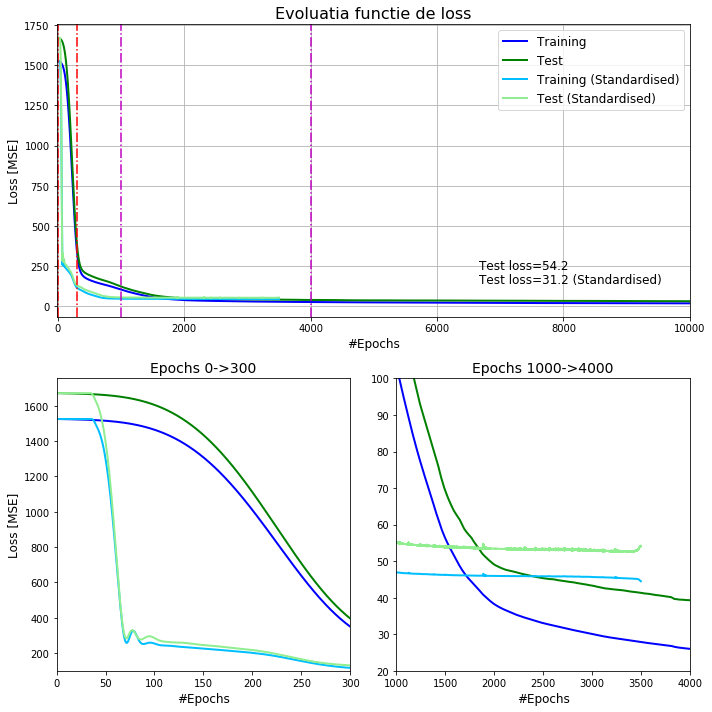

In [20]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1) # the plot will span subplots 1 and 2
plt.gcf().text(.67,.62, 'Test loss=%0.1f'%nn_1.evaluate(X_test, Y_test, verbose=0)[0],fontsize=12)
plt.gcf().text(.67,.60, 'Test loss=%0.1f (Standardised)'%nn_2.evaluate(scaler_x.transform(X_test), Y_test, verbose=0)[0],fontsize=12)
plt.plot(range(len(nn_output_unscaled['loss'])), nn_output_unscaled['loss'], linestyle='-', color='blue',
         label='Training', lw=2)
plt.plot(range(len(nn_output_unscaled['val_loss'])), nn_output_unscaled['val_loss'], linestyle='-', color='green',
         label='Test', lw=2)
plt.plot(range(len(nn_output_scaled['loss'])), nn_output_scaled['loss'], linestyle='-', color='deepskyblue',
         label='Training (Standardised)', lw=2)
plt.plot(range(len(nn_output_scaled['val_loss'])), nn_output_scaled['val_loss'], linestyle='-', color='lightgreen',
         label='Test (Standardised)', lw=2)
plt.xlabel('#Epochs', fontsize=12)
plt.ylabel('Loss [MSE]', fontsize=12)
plt.axvline(10, ls='-.',color='r')
plt.axvline(300, ls='-.',color='r')
plt.axvline(1000, ls='-.',color='m')
plt.axvline(4000, ls='-.',color='m')
plt.title('')
plt.legend(fontsize=12, loc='upper right')
plt.grid()
plt.xlim(-20,10000)
plt.title('Evoluatia functie de loss',fontsize=16)

plt.subplot(2, 2, 3)
plt.plot(range(len(nn_output_unscaled['loss'])), nn_output_unscaled['loss'], linestyle='-', color='blue',
         label='Training', lw=2)
plt.plot(range(len(nn_output_unscaled['val_loss'])), nn_output_unscaled['val_loss'], linestyle='-', color='green',
         label='Test', lw=2)
plt.plot(range(len(nn_output_scaled['loss'])), nn_output_scaled['loss'], linestyle='-', color='deepskyblue',
         label='Training (Standardised)', lw=2)
plt.plot(range(len(nn_output_scaled['val_loss'])), nn_output_scaled['val_loss'], linestyle='-', color='lightgreen',
         label='Test (Standardised)', lw=2)

plt.xlabel('#Epochs', fontsize=12)
plt.ylabel('Loss [MSE]', fontsize=12)
plt.title('Epochs 0->300',fontsize=14)
plt.xlim(0,300)
plt.ylim(100,)

plt.subplot(2, 2, 4)
plt.plot(range(len(nn_output_unscaled['loss'])), nn_output_unscaled['loss'], linestyle='-', color='blue',
         label='Training', lw=2)
plt.plot(range(len(nn_output_unscaled['val_loss'])), nn_output_unscaled['val_loss'], linestyle='-', color='green',
         label='Test', lw=2)
plt.plot(range(len(nn_output_scaled['loss'])), nn_output_scaled['loss'], linestyle='-', color='deepskyblue',
         label='Training (Standardised)', lw=2)
plt.plot(range(len(nn_output_scaled['val_loss'])), nn_output_scaled['val_loss'], linestyle='-', color='lightgreen',
         label='Test (Standardised)', lw=2)

plt.xlabel('#Epochs', fontsize=12)
plt.title('Epochs 1000->4000',fontsize=14)
plt.xlim(1000,4000)
plt.ylim(20,100)
plt.tight_layout()

Formula functie de loss este: 
$ {MSE} ={\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$, unde $ Y_{i}$ sunt datele observate, iar ${\hat {Y_{i}}}$ sunt predictiile facute de model.

### Vizualizare model

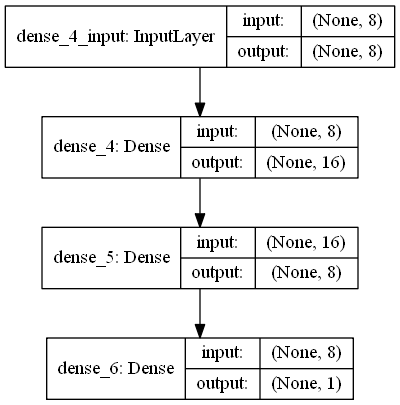

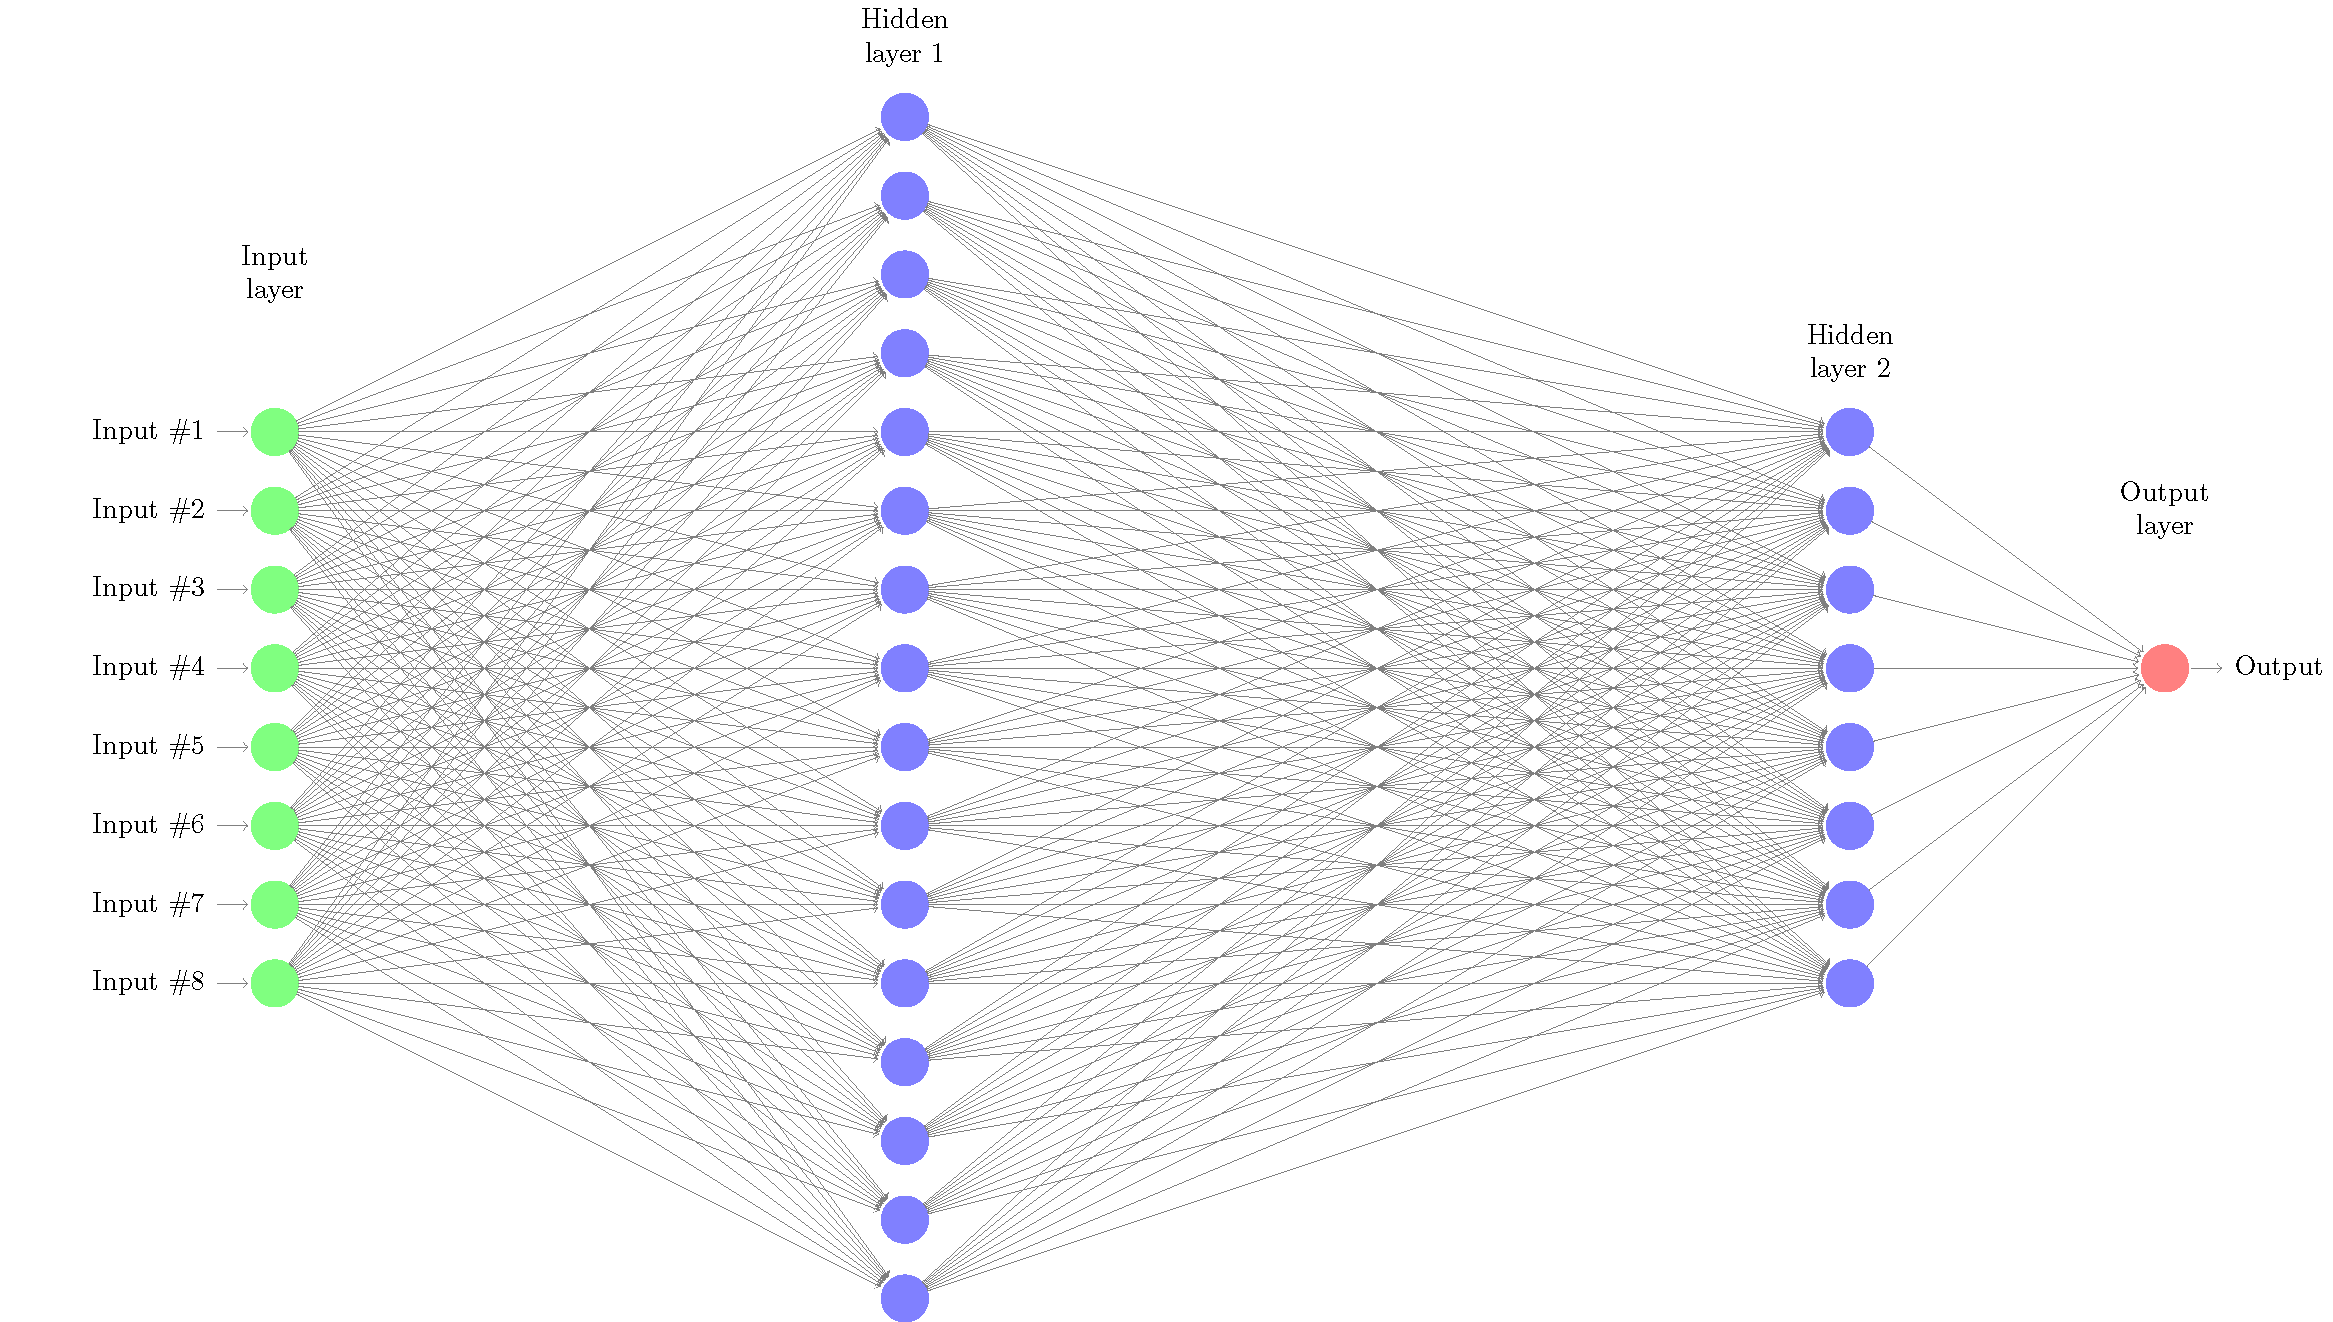

In [24]:
plot_model(nn_2, to_file='keras_plot_model_nn_2.png', show_shapes=True)
display(Image(filename='keras_plot_model_nn_2.png', height=400, width=300))
display(Image(filename='plot_model_final.png', height=700, width=700))

### Coeficientul de determinare

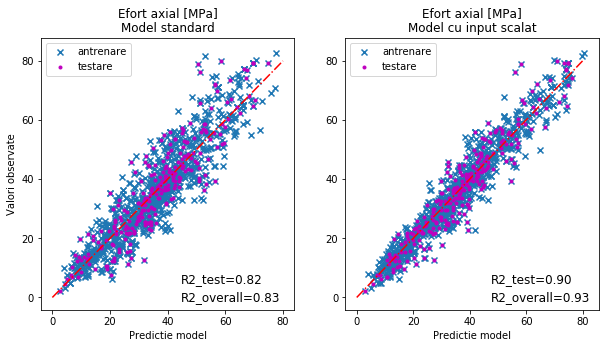

In [35]:
Y_predicted_unscaled = nn_1.predict(X_data)
Y_test_predicted_unscaled = nn_1.predict(X_test)
Y_predicted_scaled = nn_2.predict(X_data_scaled)
Y_test_predicted_scaled = nn_2.predict(scaler_x.transform(X_test))

fig = plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot([0,80],[0,80], c='r', ls='-.')
plt.scatter(Y_predicted_unscaled, Y_data, marker='x',label='antrenare')
plt.scatter(Y_test_predicted_unscaled, Y_test, marker='.', color='m', label='testare')
plt.legend()
plt.title('Efort axial [MPa]\nModel standard')
plt.xlabel('Predictie model')
plt.ylabel('Valori observate')
plt.gcf().text(.32,.15, 'R2_overall=%0.2f'%r2_score(Y_data,Y_predicted_unscaled),fontsize=12)
plt.gcf().text(.32,.2, 'R2_test=%0.2f'%r2_score(Y_test,Y_test_predicted_unscaled),fontsize=12)
plt.subplot(1,2,2)
plt.plot([0,80],[0,80], c='r', ls='-.')
plt.scatter(Y_predicted_scaled, Y_data, marker='x',label='antrenare')
plt.scatter(Y_test_predicted_scaled, Y_test, marker='.', color='m', label='testare')
plt.legend()
plt.title('Efort axial [MPa]\nModel cu input scalat')
plt.xlabel('Predictie model')
plt.gcf().text(.75,.15, 'R2_overall=%0.2f'%r2_score(Y_data,Y_predicted_scaled),fontsize=12)
plt.gcf().text(.75,.2, 'R2_test=%0.2f'%r2_score(Y_test,Y_test_predicted_scaled),fontsize=12);